In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# display all rows 
pd.set_option('display.max_rows', None)
bank_max = pd.read_csv('fake_transactional_data_24.csv')

In [3]:
#head of the data
bank_max.info()
print(bank_max.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10148280 entries, 0 to 10148279
Data columns (total 4 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   from_totally_fake_account      float64
 1   monopoly_money_amount          float64
 2   to_randomly_generated_account  object 
 3   not_happened_yet_date          object 
dtypes: float64(2), object(2)
memory usage: 309.7+ MB
(10148280, 4)


Date comes in a day first format

In [4]:
#take sample of 20% of the data
#bank = bank_max.sample(frac=1, random_state=1)

# full dataset
bank = bank_max

bank.shape

(10148280, 4)

In [5]:
# filter out rows where there is a numeric value in the 'to_randomly_generated_account' column - only looking at C2B payments
bank = bank[bank['to_randomly_generated_account'].str.isnumeric() == False]

In [6]:
#sort the data by the 'to_randomly_generated_account' column - check account numbers have been removed from the beneficiary column
bank = bank.sort_values(by='to_randomly_generated_account', ascending=False)
bank.head()

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
9474872,100214.0,74.99,WINE_CELLAR,09/12/2025
552937,61802.0,24.99,WINE_CELLAR,20/01/2025
7910414,11630.0,24.99,WINE_CELLAR,14/10/2025
552917,53177.0,74.99,WINE_CELLAR,20/01/2025
1935308,28673.0,24.99,WINE_CELLAR,11/03/2025


In [7]:
#concert 'not_happened_yet_date' to datetime format
bank['not_happened_yet_date'] = pd.to_datetime(rfm_merged['not_happened_yet_date'],dayfirst=True)

bank.head()

NameError: name 'rfm_merged' is not defined

In [ ]:
# last date of the data
print(bank['not_happened_yet_date'].max())

2025-12-31 00:00:00


Now set our benchmark most recent time for recency score as the latest date

In [ ]:
now = bank['not_happened_yet_date'].max() + pd.DateOffset(days=1)
print(now)

2026-01-01 00:00:00


In [ ]:
# Create a new column and label a number for every time a transaction is made to a specific account in the 'to_randomly_generated_account' column
bank['transaction_freq_id'] = bank['from_totally_fake_account'] + 5

bank.head()
bank.shape

(7615517, 5)

use max instead of min for the recency to get lower scores first (which are better)

In [ ]:
rfm = bank.groupby('from_totally_fake_account').agg({'not_happened_yet_date': lambda date: (now - date.max()).days, # recency
                                                     'transaction_freq_id': lambda num: len(num), # frequency
                                                     'monopoly_money_amount': lambda spend: spend.sum(), # monetary value
                                                     })

rfm.columns = ['recency', 'frequency', 'monetary']

(rfm.head(5))

,recency,frequency,monetary
from_totally_fake_account,,,
1000.0,1,1335,10485.46
1002.0,1,691,9155.67
1006.0,1,1553,14715.49
1018.0,2,687,11304.51
1053.0,1,1012,13139.22


In [ ]:
# split the rececny, frequency and monetary into 4 quartiles. 

# more recent the transaction is, the lower the recency value. Should go in a lower quartile. I.e. best is the first quartile.
rfm['r_quartile'] = pd.qcut(rfm['recency'].rank(method='first'), q=4,labels=['4','3','2','1'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'].rank(method='first'), q=4, labels=['1','2','3','4'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'].rank(method='first'), q=4, labels=['1','2','3','4'])

In [ ]:
rfm['RFM_Segment'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm['RFM_Score'] = rfm.r_quartile.astype(int) + rfm.f_quartile.astype(int) + rfm.m_quartile.astype(int)
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
from_totally_fake_account,,,,,,,,
1000.0,1,1335,10485.46,4,4,1,441,9
1002.0,1,691,9155.67,4,1,1,411,6
1006.0,1,1553,14715.49,4,4,3,443,11
1018.0,2,687,11304.51,1,1,2,112,4
1053.0,1,1012,13139.22,4,3,3,433,10


In [ ]:
#show accounts with rfm score of 111 - worst lower quartile for recency, frequency and monetary
rfm[rfm['RFM_Segment']=='111'].head(5)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
from_totally_fake_account,,,,,,,,
1059.0,2,678,10709.59,1,1,1,111,3
1122.0,2,672,10966.03,1,1,1,111,3
1142.0,2,522,9020.06,1,1,1,111,3
1357.0,2,651,9801.39,1,1,1,111,3
1622.0,4,463,9052.25,1,1,1,111,3


In [ ]:
#show accounts with rfm score of 444 - best upper quartiles
rfm[rfm['RFM_Segment']=='444'].head(5)

# higher the rfm score, the better the customer is.

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
from_totally_fake_account,,,,,,,,
1214.0,1,1331,18452.83,4,4,4,444,12
1507.0,1,1372,16676.08,4,4,4,444,12
1703.0,1,1712,16994.83,4,4,4,444,12
2076.0,1,1477,19285.30,4,4,4,444,12
2100.0,1,1370,16900.24,4,4,4,444,12


# RFM Score summary statistics

In [ ]:
rfm.groupby('RFM_Score').agg({'recency': 'mean',
                              'frequency': 'mean',
                             'monetary': ['mean', 'count']}).round(1)


recency frequency monetary      
             mean      mean     mean count
RFM_Score                                 
3             2.7     565.0   9337.2   491
4             2.1     637.1  10640.1   604
5             1.7     684.6  11268.9   778
6             1.4     724.8  11840.2   956
7             1.2     830.8  12306.5  1103
8             1.1     942.7  13103.3  1147
9             1.0    1085.1  13894.8  1129
10            1.0    1227.2  15072.5  1047
11            1.0    1335.7  15810.8   622
12            1.0    1469.3  16564.0   265

The higher the RFM score, the lower the recency, higher the frequency and higher the monetary spend.

# K-means clustering


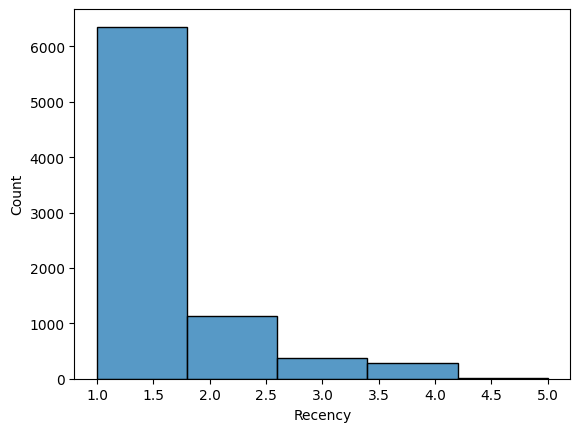

In [ ]:
sns.histplot(rfm['recency'],bins=5)
plt.xlabel('Recency')
plt.show()

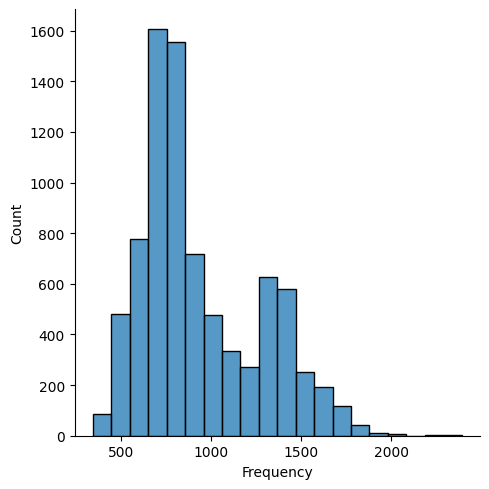

In [ ]:
sns.displot(rfm['frequency'],bins=20)
plt.xlabel('Frequency')
plt.show()

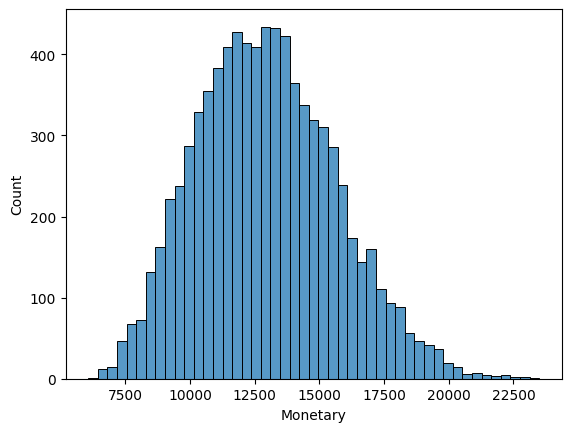

In [ ]:
sns.histplot(rfm['monetary'])
plt.xlabel('Monetary')
plt.show()


All rfm features are log-normal and have a heavy right-skew

## Log transformation

In [ ]:
rfm_features = rfm[['recency', 'frequency', 'monetary']]
rfm_features.head()


,recency,frequency,monetary
from_totally_fake_account,,,
1000.0,1,1335,10485.46
1002.0,1,691,9155.67
1006.0,1,1553,14715.49
1018.0,2,687,11304.51
1053.0,1,1012,13139.22


In [ ]:
#create a new dataframe with the log of the rfm features
rfm_features_log = rfm_features.copy()
rfm_features_log['recency_log'] = np.log(rfm_features['recency'])
rfm_features_log['frequency_log'] = np.log(rfm_features['frequency'])
rfm_features_log['monetary_log'] = np.log(rfm_features['monetary'])
rfm_features_log.drop(['recency', 'frequency', 'monetary'], axis=1, inplace=True)


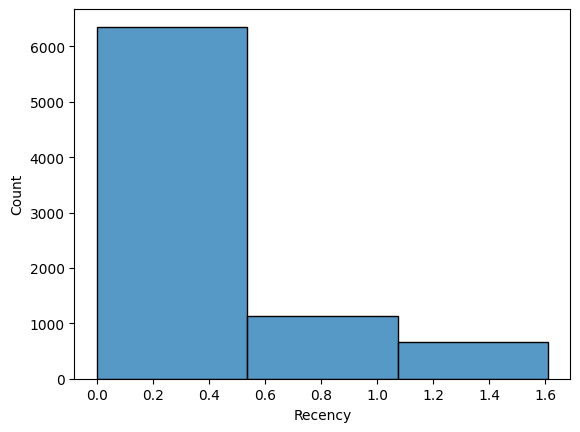

In [ ]:
# plot the rfm features_log
sns.histplot(rfm_features_log['recency_log'],bins=3)
plt.xlabel('Recency')
plt.show()


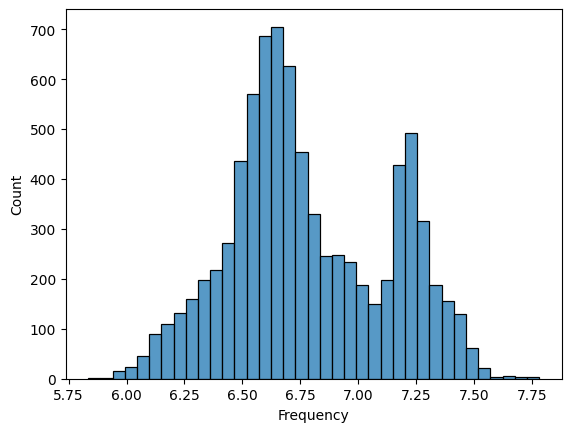

In [ ]:
sns.histplot(rfm_features_log['frequency_log'])
plt.xlabel('Frequency')
plt.show()

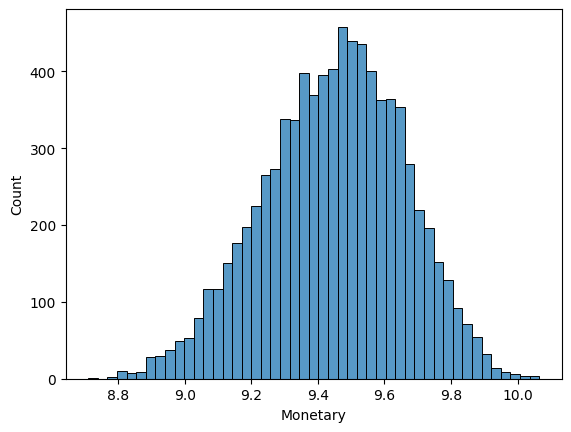

In [ ]:
sns.histplot(rfm_features_log['monetary_log'])
plt.xlabel('Monetary')
plt.show()

# Standardising and scaling data

In [ ]:
rfm.describe()

,recency,frequency,monetary,RFM_Score
count,8142.000000,8142.000000,8142.000000,8142.000000
mean,1.336895,935.337386,12944.370357,7.500000
std,0.729205,331.352131,2685.184598,2.402439
min,1.000000,342.000000,6063.340000,3.000000
25%,1.000000,699.000000,10980.735000,6.000000
50%,1.000000,818.000000,12829.960000,8.000000
75%,1.000000,1192.750000,14750.287500,9.000000
max,5.000000,2391.000000,23494.220000,12.000000


rfm features have different means and variances

In [ ]:
#import standard scaler
from sklearn.preprocessing import StandardScaler

#standardize the data
scaler = StandardScaler()
scaler.fit(rfm_features_log)
rfm_normalized = scaler.transform(rfm_features_log)
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_features.index, columns=rfm_features.columns)
rfm_normalized.describe().round(2)

,recency,frequency,monetary
count,8142.00,8142.00,8142.00
mean,0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-0.50,-2.78,-3.50
25%,-0.50,-0.68,-0.68
50%,-0.50,-0.22,0.06
75%,-0.50,0.89,0.72
max,3.63,2.92,2.93


As you can see all rfm features have been scaled to unit deviation and centred on the same mean

# K-Means Clustering

In [ ]:
rfm_normalized.head()   

,recency,frequency,monetary
from_totally_fake_account,,,
1000.0,-0.501287,1.216525,-0.896695
1002.0,-0.501287,-0.714062,-1.540641
1006.0,-0.501287,1.659948,0.712554
1018.0,1.276265,-0.731082,-0.539566
1053.0,-0.501287,0.404467,0.174577


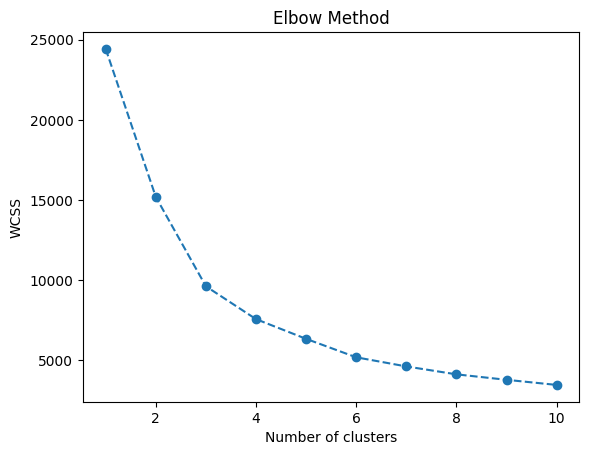

In [ ]:
#import KMeans
from sklearn.cluster import KMeans

# vary the number of clusters from 1 to 10
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)
    
# plot the elbow graph
# point plot
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

4 is the best number of clusters

In [ ]:
# select k clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(rfm_normalized)


# Analysis of clustering

Summary statistics of the non-scaled RFM data with labelled clusters.

In [ ]:
rfm_kmeans_cluster = rfm.assign(Cluster=clusters) 

# calculate average RFM values and size for each cluster
rfm_kmeans_cluster.groupby('Cluster').agg({'recency': 'mean',
                                           'frequency': 'mean',
                                           'monetary': ['mean','count']}).round(2)



recency frequency  monetary      
           mean      mean      mean count
Cluster                                  
0          2.56    669.89  11732.70  1701
1          1.03    803.24  14605.78  2038
2          1.00    772.05  10390.48  2037
3          1.01   1380.54  14583.16  2366

`count` column gives the number of accounts in each cluster - total of 8142 customers.

# Snake plots

Pivot wider, so each row represents one observations for a metric, given a specific account and cluster.

In [ ]:
rfm_normalized['Cluster'] = rfm_kmeans_cluster['Cluster']  

# pivot wide for plotting
rfm_melt = pd.melt(rfm_normalized.reset_index(), 
                   id_vars=['from_totally_fake_account', 'Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric', value_name='Value')


Snake plots average values for each RFM metric for each cluster, using the original scaled and log transformed training data that has been labelled with KMeans assigned clusters.

Some negative values due to the Standardisation.

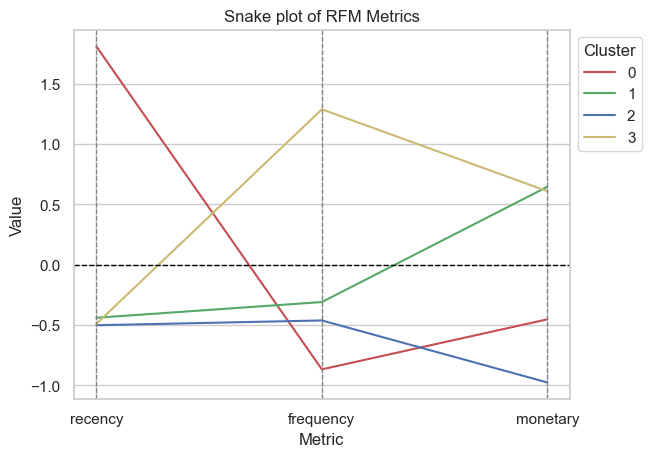

In [ ]:
# visualize the clusters using a snake plot
sns.set(style='whitegrid')

# 3 cluster palette
palette4 =['r','g','b','y']

plt.title('Snake plot of RFM Metrics')
snake=sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=palette4, data=rfm_melt,err_style=None)
sns.move_legend(snake, loc="upper left", bbox_to_anchor=(1, 1))
# vertical lines for each metric
plt.axvline(x=0, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=1, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=2, color='grey', linestyle='--',linewidth=0.9)
plt.axhline(y=0, color='black', linestyle='--',linewidth=1)
plt.show()


# Relative importance heatmaps and snake plots

In [ ]:
rfm_kmeans_cluster.tail()
# drop every column except the cluster column and recency, frequency and monetary columns
rfm_kmeans_cluster_rel_imp = rfm_kmeans_cluster.drop(['r_quartile', 'f_quartile', 'm_quartile', 'RFM_Segment', 'RFM_Score'], axis=1)

rfm_rel_imp_calc=rfm.drop(['r_quartile', 'f_quartile', 'm_quartile', 'RFM_Segment', 'RFM_Score'], axis=1)

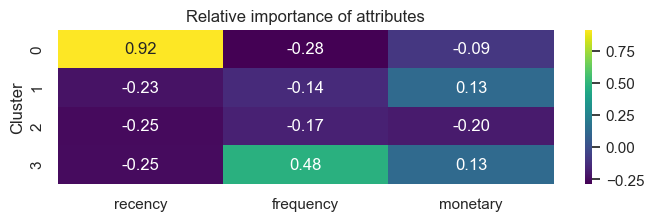

In [ ]:

cluster_avg = rfm_kmeans_cluster_rel_imp.groupby(['Cluster']).mean()
population_avg = rfm_rel_imp_calc.mean()

relative_imp = cluster_avg / population_avg - 1

# plot the relative importance of the RFM values for each cluster
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')

# green-red colour map
#gr_cmap = sns.diverging_palette(0, 130, n=5)

sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='viridis')
plt.show()

Further the relative score is from 0, the more important that property is to that particular cluster as compared to the population average.

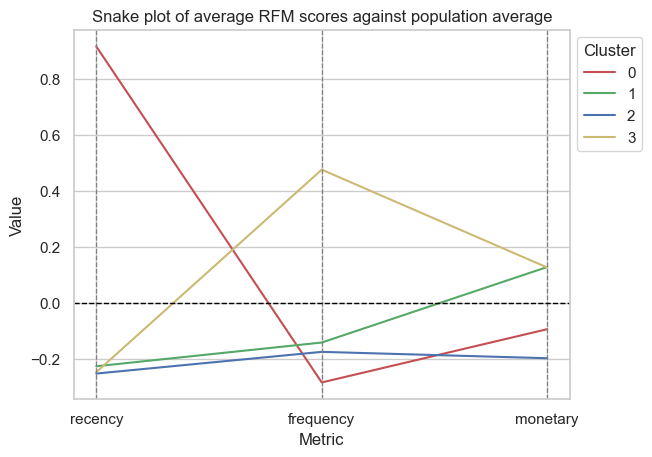

In [ ]:
# snake plot of average RFM scores against population average
relative_imp = relative_imp.reset_index()
relative_imp_melt = pd.melt(relative_imp, id_vars=['Cluster'], value_vars=['recency', 'frequency', 'monetary'], var_name='Metric', value_name='Value')

plt.title('Snake plot of average RFM scores against population average')
snake=sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=palette4, data=relative_imp_melt,err_style=None)
sns.move_legend(snake, loc="upper left", bbox_to_anchor=(1, 1))
plt.axvline(x=0, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=1, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=2, color='grey', linestyle='--',linewidth=0.9)
plt.axhline(y=0, color='black', linestyle='--',linewidth=1)
plt.show()


# Spending behaviours for each cluster


In [ ]:
rfm_melt['from_totally_fake_account'].nunique()
rfm_melt.head(10)

,from_totally_fake_account,Cluster,Metric,Value
0,1000.0,3,recency,-0.501287
1,1002.0,2,recency,-0.501287
2,1006.0,3,recency,-0.501287
3,1018.0,0,recency,1.276265
4,1053.0,1,recency,-0.501287
5,1059.0,0,recency,1.276265
6,1071.0,2,recency,-0.501287
7,1078.0,1,recency,-0.501287
8,1086.0,3,recency,-0.501287
9,1087.0,2,recency,-0.501287


In [ ]:
# join the rfm_melt dataframe with the original bank dataframe on the 'from_totally_fake_account' column
rfm_merged = bank.merge(rfm_melt, on='from_totally_fake_account')


In [ ]:
# print number of rows in rfm_merged - many more as we have multiple metrics for each account
print(rfm_merged.shape)

rfm_merged.head()

(22846551, 8)


,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,transaction_freq_id,Cluster,Metric,Value
0,100214.0,74.99,WINE_CELLAR,2025-12-09,100219.0,2,recency,-0.501287
1,100214.0,74.99,WINE_CELLAR,2025-12-09,100219.0,2,frequency,-0.100051
2,100214.0,74.99,WINE_CELLAR,2025-12-09,100219.0,2,monetary,-0.294396
3,100214.0,49.99,WINE_CELLAR,2025-03-11,100219.0,2,recency,-0.501287
4,100214.0,49.99,WINE_CELLAR,2025-03-11,100219.0,2,frequency,-0.100051


In [ ]:
# regex search patterns
val_replace_cafe = ['coffee', 'tea', 'cafe']
val_replace_book_store = ['book', 'book store', 'bookshop']  
val_replace_alcohol = ['WINE_CELLAR', 'alcohol', 'liquor','whiskey']
val_replace_pub = ['bar','pub','LOCAL_WATERING_HOLE']
val_replace_restaurant = ['restaurant','SEAFOOD_RESAURANT' , 'steak house', 'KEBAB_SHOP', 'SANDWICH_SHOP', 'roasterie','lunch']
val_replace_entertainment = ['cinema','streaming']
val_replace_home = ['DIY', 'home', 'COOKSHOP']
val_replace_supermarket = ['supermarket']
val_replace_green_grocer = ['GREENGROCER']
val_replace_clothing = ['clothing', 'fashion', 'clothes', 'ACCESSORY_SHOP']
val_replace_gym = ['gym']
val_replace_takeaway = ['takeaway']
val_replace_sports_store = ['sport','sportsware','running','trainer','FASHIONABLE_SPORTSWARE_SHOP']
val_replace_children = ['child','toy', 'kids', 'CHILDRENDS_SHOP']
val_replace_pets = ['pet', 'PET_TOY_SHOP']
val_replace_tech_store = ['tech','electronics']
val_replace_butcher = ['BUTCHER', 'TURKEY_FARM']
val_replace_game = ['game', 'DVD']
val_replace_jeweller = ['JEWLLERY_SHOP']

# replacement group categories
merchant_names = ['Cafe', 'Book Store','Alcohol', 'Pub', 'Restaurant', 'Entertainment', 'Home',
                  'Supermarket', 'Green Grocer', 'Clothing', 'Gym', 'Takeaway', 'Sports Store', 'Children','Pets', 'Tech Store', 'Butcher', 'Game', 'Jewellery']



In [ ]:
grouping_conditions = [
    
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_cafe), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_book_store), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_alcohol), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_pub), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_restaurant), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_entertainment), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_home), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_supermarket), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_green_grocer), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_clothing), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_gym), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_takeaway), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_sports_store), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_children), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_pets), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_tech_store), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_butcher), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_game), case=False, regex=True),
    rfm_merged['to_randomly_generated_account'].str.contains('|'.join(val_replace_jeweller), case=False, regex=True)]


In [ ]:
# assign new merchant categories
rfm_merged['business_name'] = np.select(grouping_conditions, merchant_names, default='')

#### Cluster 0 summary stats

In [ ]:
# filter rfm_merged for 'Cluster' == 0 and save to rfm_merged_cluster_0
rfm_merged_cluster_0 = rfm_merged[rfm_merged['Cluster'] == 0]

In [ ]:
mean_spend_c0 = rfm_merged_cluster_0.groupby('business_name').agg({'monopoly_money_amount':'mean'}).reset_index()

# rename 'monopoly_money_amount' column to 'average_spend'
mean_spend_c0.rename(columns={'monopoly_money_amount':'mean_spend'}, inplace=True)
mean_spend_c0

NameError: name 'rfm_merged_cluster_0' is not defined

#### Cluster 1 summary stats

In [ ]:
# filter rfm_merged for 'Cluster' == 0 and save to rfm_merged_cluster_1
rfm_merged_cluster_1 = rfm_merged[rfm_merged['Cluster'] == 1]

In [ ]:
mean_spend_c1 = rfm_merged_cluster_1.groupby('business_name').agg({'monopoly_money_amount':'mean'}).reset_index()

# rename 'monopoly_money_amount' column to 'average_spend'
mean_spend_c1.rename(columns={'monopoly_money_amount':'mean_spend'}, inplace=True)
mean_spend_c1

,business_name,mean_spend
0,,79.465358
1,Alcohol,14.054185
2,Book Store,11.806208
3,Butcher,22.806832
4,Cafe,2.840035
5,Children,51.127903
6,Clothing,98.605481
7,Entertainment,7.354840
8,Game,18.726665
9,Green Grocer,21.677384


#### Cluster 2 summary stats

In [ ]:
# filter rfm_merged for 'Cluster' == 0 and save to rfm_merged_cluster_0
rfm_merged_cluster_2 = rfm_merged[rfm_merged['Cluster'] == 0]

In [ ]:
mean_spend_c2 = rfm_merged_cluster_2.groupby('business_name').agg({'monopoly_money_amount':'mean'}).reset_index()

# rename 'monopoly_money_amount' column to 'average_spend'
mean_spend_c2.rename(columns={'monopoly_money_amount':'mean_spend'}, inplace=True) 
mean_spend_c2

,business_name,mean_spend
0,,70.333323
1,Alcohol,13.821160
2,Book Store,11.731131
3,Butcher,22.555051
4,Cafe,2.855711
5,Children,49.242037
6,Clothing,94.829322
7,Entertainment,7.349319
8,Game,19.111521
9,Green Grocer,21.751710


#### Cluster 3 summary stats

In [ ]:
# filter rfm_merged for 'Cluster' == 0 and save to rfm_merged_cluster_0
rfm_merged_cluster_3 = rfm_merged[rfm_merged['Cluster'] == 3]

In [ ]:
mean_spend_c3 = rfm_merged_cluster_3.groupby('business_name').agg({'monopoly_money_amount':'mean'}).reset_index()

# rename 'monopoly_money_amount' column to 'average_spend'
mean_spend_c3.rename(columns={'monopoly_money_amount':'mean_spend'}, inplace=True)
mean_spend_c3

,business_name,mean_spend
0,,72.994456
1,Alcohol,13.873581
2,Book Store,11.739204
3,Butcher,22.671451
4,Cafe,2.557353
5,Children,49.949492
6,Clothing,94.323919
7,Entertainment,7.349229
8,Game,18.405124
9,Green Grocer,21.898616


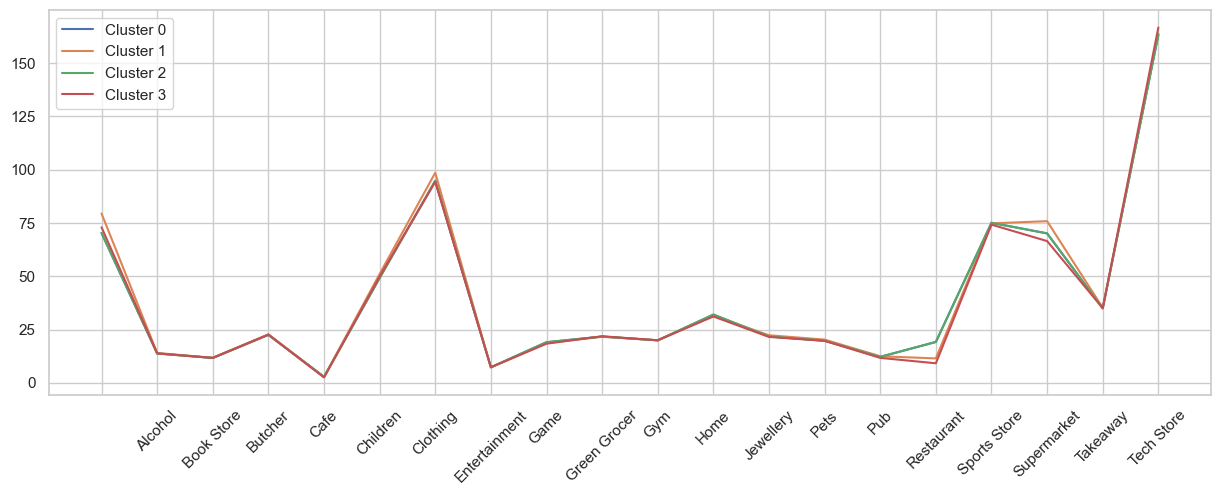

In [ ]:
# plot the mean_spend for each cluster snake plot
plt.figure(figsize=(15, 5))
plt.plot(mean_spend_c0['business_name'], mean_spend_c0['mean_spend'], label='Cluster 0')
plt.xticks(rotation=45)

# add mean_spend for cluster 1
plt.plot(mean_spend_c1['business_name'], mean_spend_c1['mean_spend'], label='Cluster 1')

# add mean_spend for cluster 2
plt.plot(mean_spend_c2['business_name'], mean_spend_c2['mean_spend'], label='Cluster 2')

# add mean_spend for cluster 3
plt.plot(mean_spend_c3['business_name'], mean_spend_c3['mean_spend'], label='Cluster 3')
# add legend
plt.legend()
